In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime as dt
import json

## 퀀트함수
from quant_functions import anal_funcs, data_funcs
import myfuncs
from fredapi import Fred
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')

# 시각화 관련
import plotly_express as px
import plotly.figure_factory as ff
import cufflinks as cf
cf.go_offline(connected=True)
## cf.getThemes()
cf.set_config_file(theme='polar')
import plotly.graph_objects as go
import seaborn as sns
sns.set_style('whitegrid')
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker
from matplotlib.ticker import LogLocator
import matplotlib.pyplot as plt
## figure size 설정
figsize=(12, 8)
plt.rcParams["figure.figsize"] = figsize
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

import graphModule as gm

## color 설정
with open('colors.json') as f:
    mycolors = json.load(f)

# 블루 - 퍼플 테마
cmap_colors = [mycolors['color_cont'], mycolors['color_cont2'], mycolors['color_cont3']]
# LinearSegmentedColormap 생성
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors, N=256)    

## shock case
with open('shockCase.json', encoding='utf-8') as f:
    shock_cases = json.load(f)

## Data Load

In [2]:
## 보간용 필수 데이터
gold = pd.read_csv(f"gold.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Gold'})
gold.index = pd.to_datetime(gold.index)
ds20 = fred.get_series('DGS20')
ds10 = fred.get_series('DGS10')

## load data
df_ref = data_funcs.get_merged_df('^IXIC', '^GSPC', '^DJI', 'GC=F')
df_ref = df_ref.fillna(method = 'pad')
df_ref['Gold'] = gold['Gold']
df_ref['DGS10'] = ds10
df_ref['DGS20'] = ds20

## Imputation
df_ref = myfuncs.imputation(df_ref, '^GSPC', '^DJI')
df_ref = myfuncs.imputation(df_ref, 'DGS10', 'DGS20')
df_ref = myfuncs.imputation(df_ref, 'DGS20', 'DGS10')
df_ref = myfuncs.imputation(df_ref, 'GC=F', 'Gold')
df_ref['Gold']['1975-01-02'] = 1
df_ref['Gold']['1975-01-03'] = 1

## column selection
df_ref = df_ref[['^GSPC', '^DJI', '^IXIC', 'DGS10', 'DGS20', 'Gold']]
df_ref.columns = ['S&P500', 'DowJones', 'NASDAQ', 'DGS10', 'DGS20', 'Gold']

## 75년 이전에는 Gold 데이터가 없음
df_ref = df_ref['1975':]
df_ref = df_ref/df_ref.iloc[0]

[*********************100%%**********************]  4 of 4 completed

0.9189857354609675
0.7566414076085713
1.1913266480956388
0.9953424146502148


In [3]:
## 프로젝트마다 필요한 데이터
tickers = ['QQQ', 'QYLD', 'JEPQ']
df_ori = data_funcs.get_merged_df(*tickers)
df_ori = df_ori[tickers]

[*********************100%%**********************]  3 of 3 completed


In [4]:
## 보간 시계열 데이터
df_imp = pd.concat([df_ref, df_ori], axis=1)
df_imp = myfuncs.imputation(df_imp, 'NASDAQ', 'QQQ')
df_imp = myfuncs.imputation(df_imp, 'QQQ', 'QYLD')
df_imp = myfuncs.imputation(df_imp, 'QYLD', 'JEPQ')

## 비보간 시계열 데이터
df_cut = df_ori.dropna()
df_cut = df_cut/df_cut.iloc[0]

1.0449518645756142
0.6065329045263645
1.0720510408333803


## Visualization

In [5]:
assets = ['JEPQ', 'QQQ']

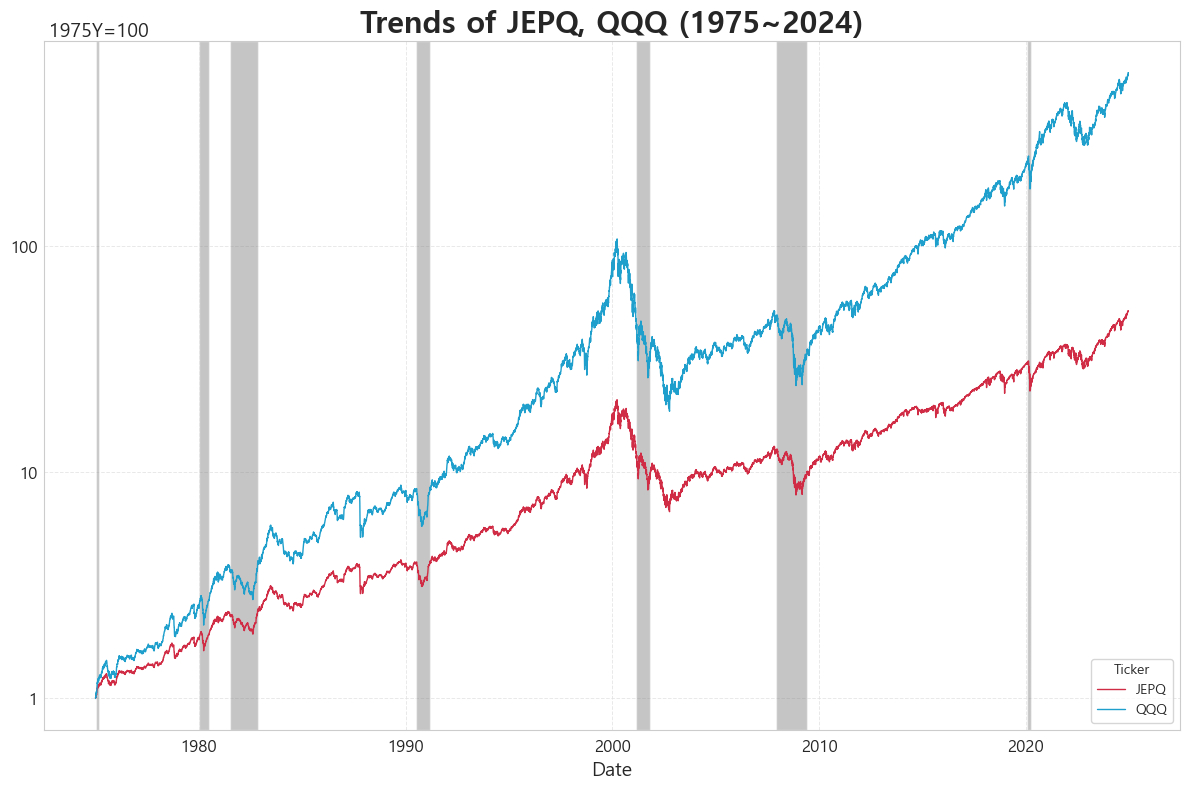

In [6]:
gm.trend_plot(df_imp, assets, colors=[mycolors['color_norm'], mycolors['color_cont']])

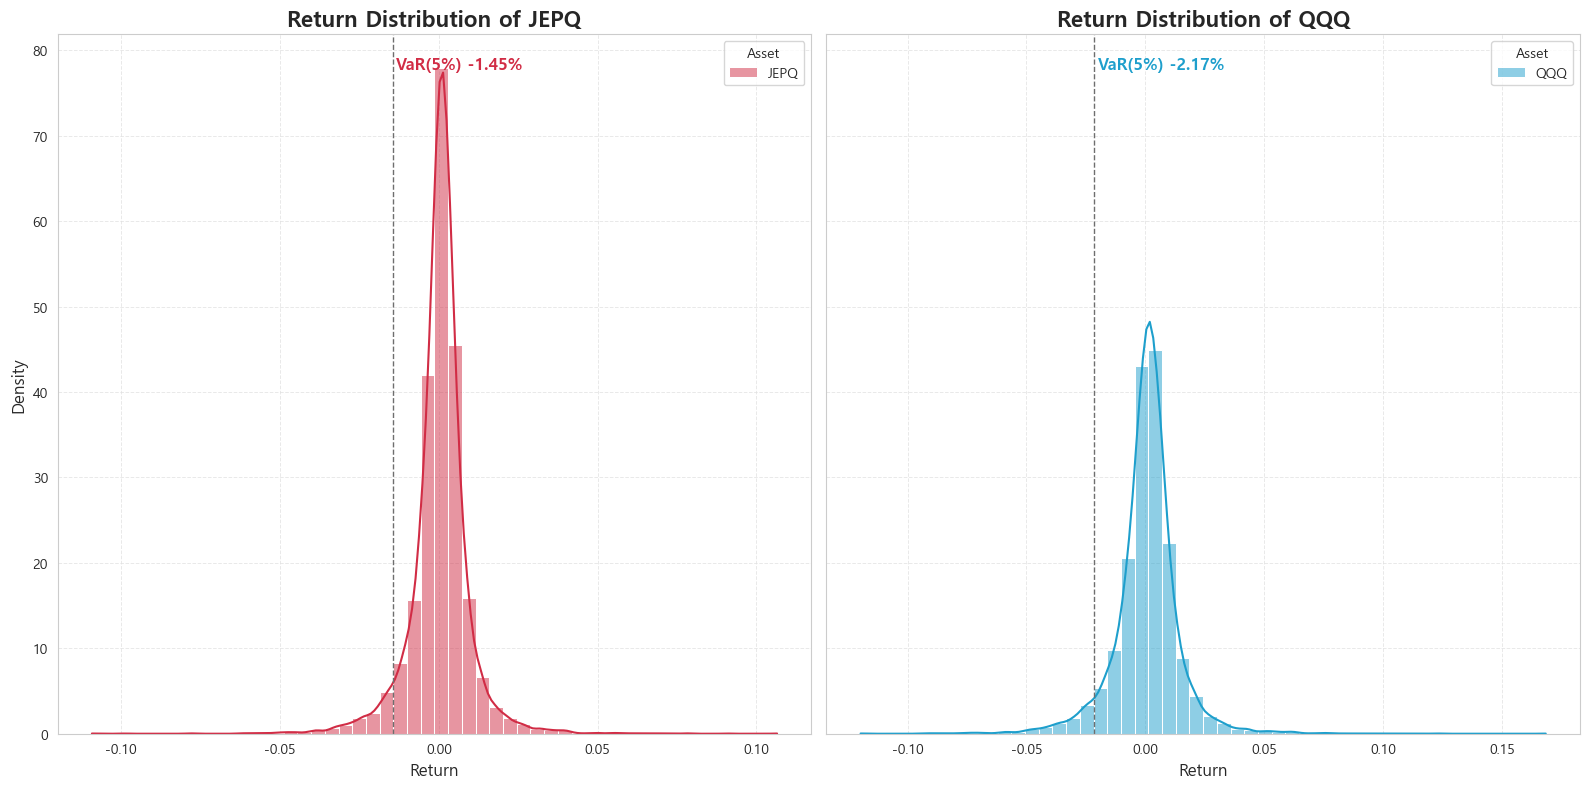

In [7]:
gm.asset_histogram_plot(df_imp.pct_change(), assets, colors=[mycolors['color_norm'], mycolors['color_cont']])

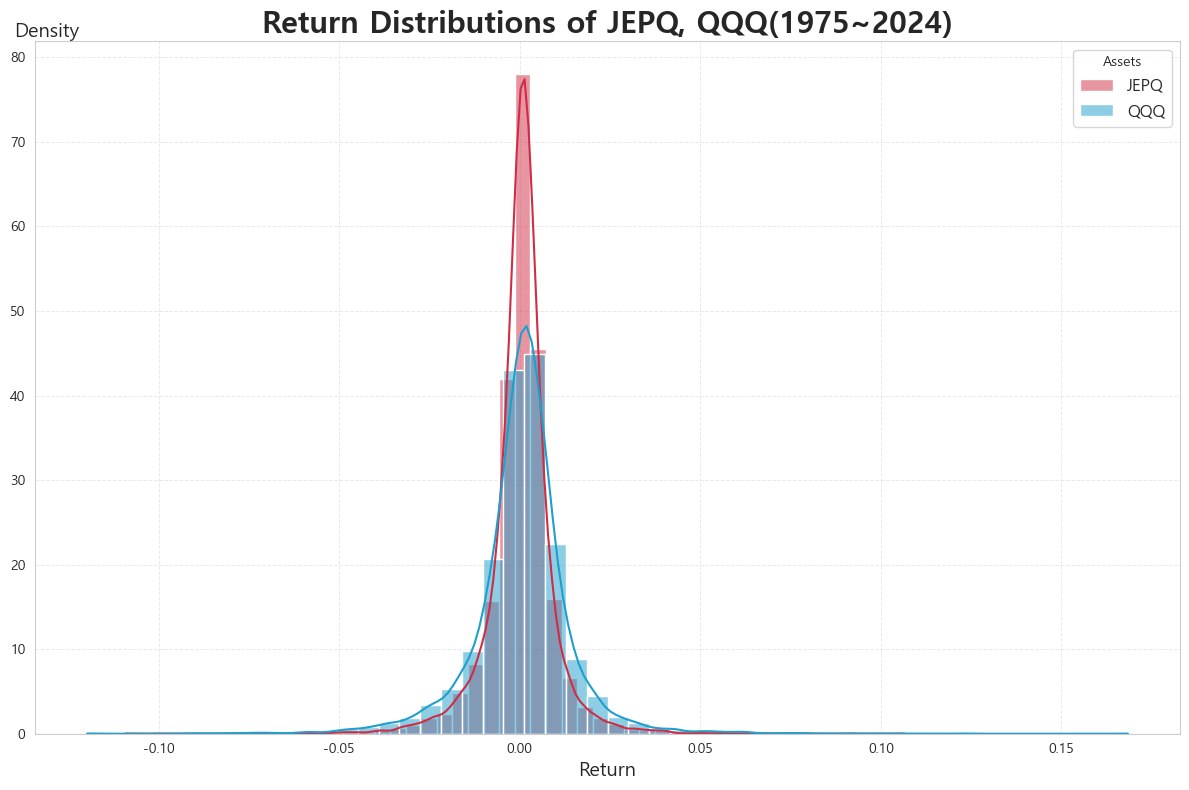

In [8]:
gm.asset_histogram_merged_plot(df_imp.pct_change(), assets, colors=[mycolors['color_norm'], mycolors['color_cont']])

In [9]:
return_risk_df = anal_funcs.get_Vol_report(df_imp[assets], method='a', rf=0)

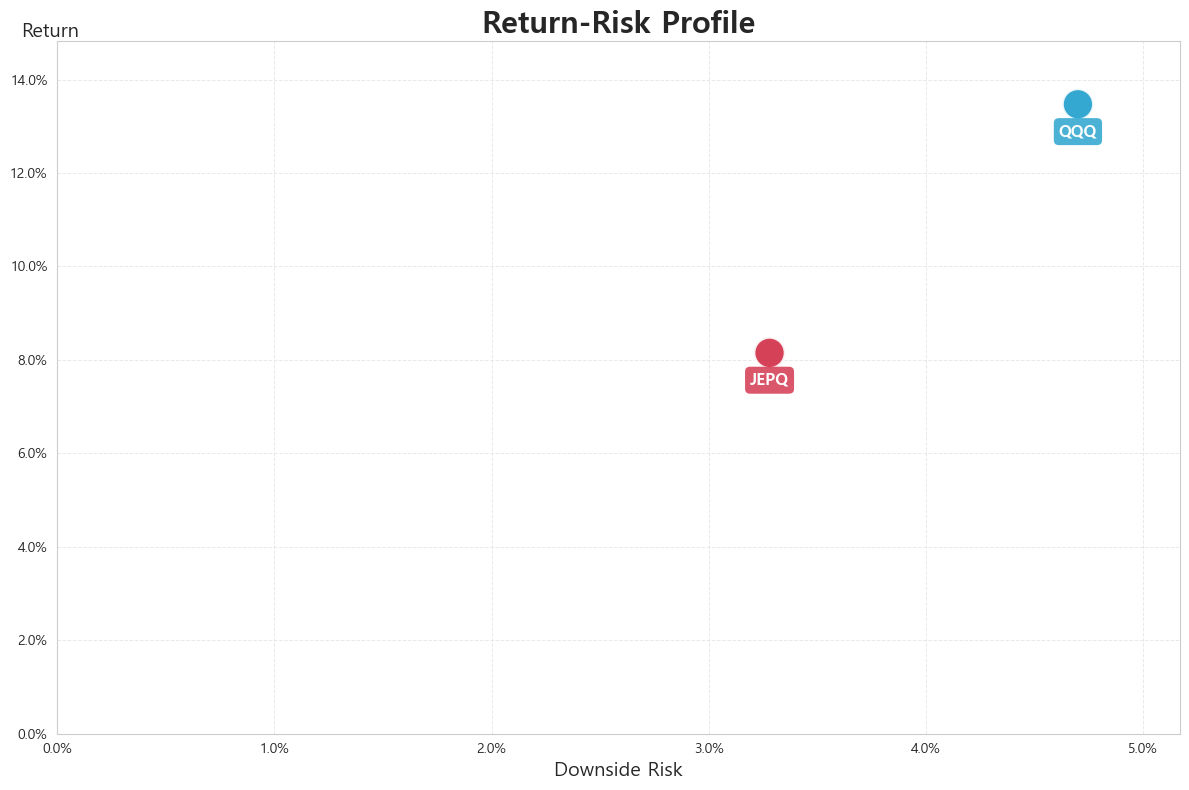

In [10]:
gm.return_risk_profile_plot(return_risk_df, assets, colors=[mycolors['color_norm'], mycolors['color_cont']])

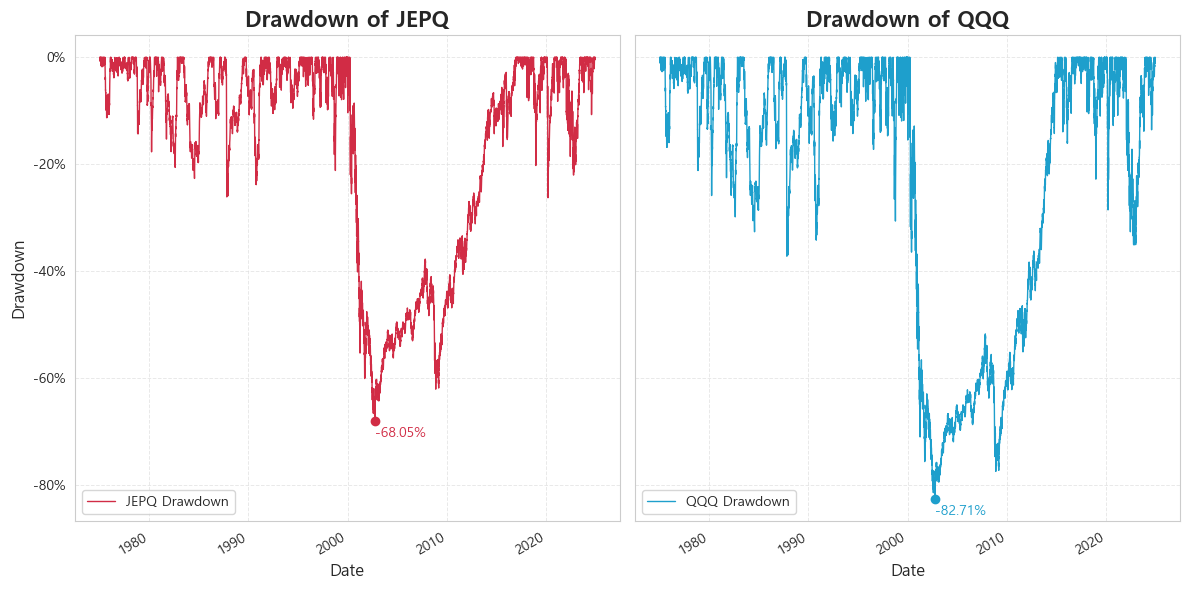

In [11]:
gm.drawdown_plot(df_imp, assets, colors=[mycolors['color_norm'], mycolors['color_cont']])

In [298]:
def get_ttr_df(df, assets):
    """
    Prepares TTR data for multiple assets.

    Parameters:
        df (DataFrame): A DataFrame containing cumulative return data for assets.
        assets (list): List of asset names in the DataFrame.

    Returns:
        pd.DataFrame: TTR data for each asset as a series.
    """
    def calculate_ttr_series(drawdown_series):
        ttr_data = []
        ttr_index = []
        in_drawdown = False
        start_date = None

        for date, value in drawdown_series.items():
            if value < 0 and not in_drawdown:
                # Start of a drawdown
                in_drawdown = True
                start_date = date
            elif value == 0 and in_drawdown:
                # Recovery point
                in_drawdown = False
                ttr_data.append((date - start_date).days)  # TTR in days
                ttr_index.append(date)

        return pd.Series(ttr_data, index=ttr_index)

    ttr_dict = {}

    for asset in assets:
        # Calculate drawdown
        drawdown = df[asset] / df[asset].cummax() - 1
        # Calculate TTR
        ttr_dict[asset] = calculate_ttr_series(drawdown)

    return pd.DataFrame(ttr_dict)

In [299]:
ttr_df = get_ttr_df(df_imp, assets)

In [312]:
## TODO: 고치기
def ttr_area_plot(ttr_df, colors=None):
    """
    Plots an area chart showing cumulative TTR over time for multiple assets.

    Parameters:
        ttr_series (pd.Series): Time-indexed series where values are TTRs.
        colors (list): List of colors for the area. Default uses seaborn palette.

    Returns:
        None
    """
    for col in ttr_df.columns:
        ttr_series = ttr_df[col].dropna()
        if colors is None:
            colors = sns.color_palette('tab10', len(ttr_series))

        plt.figure(figsize=(10, 6))
        ttr_series.plot(kind='area', stacked=True, color=colors, alpha=0.6)

        plt.title("Cumulative Time to Recovery (TTR) Over Time", fontsize=16, fontweight='bold')
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Cumulative TTR", fontsize=12)
        plt.grid(axis='y', linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()

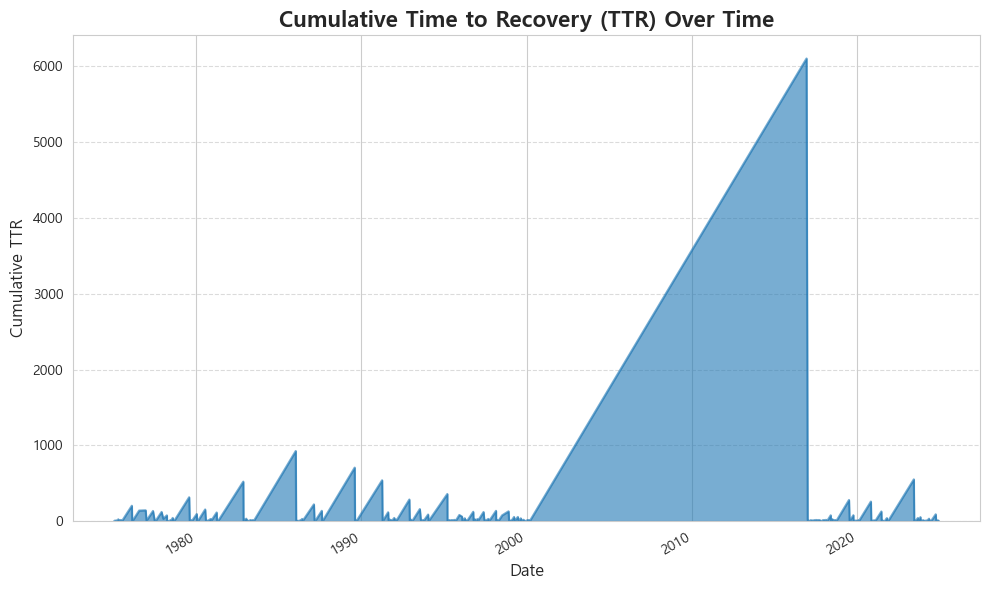

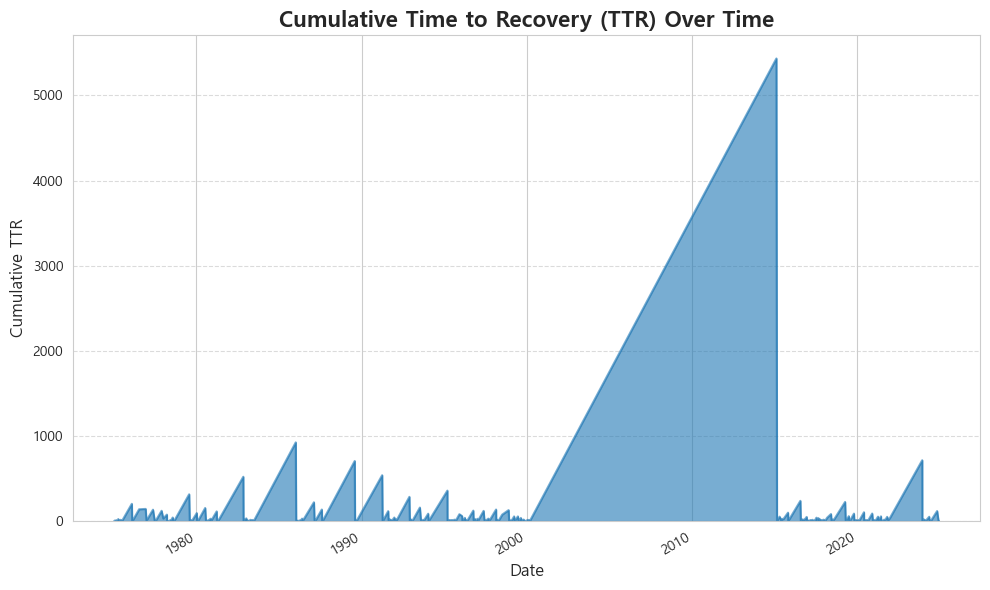

In [313]:
ttr_area_plot(ttr_df)